In [94]:
pip install ta

In [95]:
# Importing required libraries
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from keras.regularizers import l2
from matplotlib import pyplot as plt

In [96]:
#Importing Apple and Google data and converting date columns to DateTime.
appleDf = pd.read_csv("AppleStockPrices.csv", index_col=None)
googleDf = pd.read_csv("GOOG.csv", index_col=None)

appleDf['Date'] = pd.to_datetime(appleDf['Date'])
googleDf['Date'] = pd.to_datetime(googleDf['Date'])
googleDf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [97]:
googleDf.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,4858,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4.858000e+03
mean,2014-04-12 02:30:17.044051200,41.477174,41.917059,41.055491,41.494404,41.494404,1.189152e+08
min,2004-08-19 00:00:00,2.470490,2.534002,2.390042,2.490913,2.490913,1.584340e+05
25%,2009-06-16 06:00:00,12.846597,12.954195,12.712414,12.834642,12.834642,2.854912e+07
50%,2014-04-12 12:00:00,26.499958,26.728268,26.289323,26.537501,26.537501,6.168836e+07
75%,2019-02-07 18:00:00,57.367250,58.028500,56.962251,57.611249,57.611249,1.467329e+08
max,2023-12-05 00:00:00,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09
std,NaN,38.590695,39.031758,38.193016,38.618107,38.618107,1.512424e+08


In [98]:
googleDf.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [99]:
googleDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4858 entries, 0 to 4857
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4858 non-null   datetime64[ns]
 1   Open       4858 non-null   float64       
 2   High       4858 non-null   float64       
 3   Low        4858 non-null   float64       
 4   Close      4858 non-null   float64       
 5   Adj Close  4858 non-null   float64       
 6   Volume     4858 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 265.8 KB


In [100]:
googleDf.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4858,2014-04-12 02:30:17.044051200,2004-08-19 00:00:00,2009-06-16 06:00:00,2014-04-12 12:00:00,2019-02-07 18:00:00,2023-12-05 00:00:00,NaN
Open,4858.0,41.477174,2.47049,12.846597,26.499958,57.36725,151.863495,38.590695
High,4858.0,41.917059,2.534002,12.954195,26.728268,58.0285,152.100006,39.031758
Low,4858.0,41.055491,2.390042,12.712414,26.289323,56.962251,149.887497,38.193016
Close,4858.0,41.494404,2.490913,12.834642,26.537501,57.611249,150.709,38.618107
Adj Close,4858.0,41.494404,2.490913,12.834642,26.537501,57.611249,150.709,38.618107
Volume,4858.0,118915217.289625,158434.0,28549119.25,61688359.5,146732937.75,1650832619.0,151242371.191638


In [101]:
googleDf.shape

(4858, 7)

In [102]:
#Feature Engineering - calculating MACD, Stochastic Oscillator, Rolling Standard Deviation, Price Differences, and Dates.
appleDf['EMA12AAPL'] = appleDf['Close'].ewm(span=12, adjust=False).mean()
appleDf['EMA26AAPL'] = appleDf['Close'].ewm(span=26, adjust=False).mean()
appleDf['MACDAAPL'] = appleDf['EMA12AAPL'] - appleDf['EMA26AAPL']
appleDf['MACDSignalAAPL'] = appleDf['MACDAAPL'].ewm(span=9, adjust=False).mean()

appleDf['14HighAAPL'] = appleDf['High'].rolling(14).max()
appleDf['14LowAAPL'] = appleDf['Low'].rolling(14).min()
appleDf['%KAAPL'] = (appleDf['Close'] - appleDf['14LowAAPL'])*100/(appleDf['14HighAAPL'] - appleDf['14LowAAPL'])

appleDf['rollingStd5AAPL'] = appleDf['Close'].rolling(window=5).std()

googleDf['EMA12GOOG'] = googleDf['Close'].ewm(span=12, adjust=False).mean()
googleDf['EMA26GOOG'] = googleDf['Close'].ewm(span=26, adjust=False).mean()
googleDf['MACDGOOG'] = googleDf['EMA12GOOG'] - googleDf['EMA26GOOG']
googleDf['MACDSignalGOOG'] = googleDf['MACDGOOG'].ewm(span=9, adjust=False).mean()

googleDf['openCloseDiffGOOG'] = googleDf['Open'] - googleDf['Close']

appleDf['Month'] = appleDf['Date'].dt.month
appleDf['Day'] = appleDf['Date'].dt.day
appleDf['dayOfWeek'] = appleDf['Date'].dt.dayofweek
appleDf['isMonthStart'] = appleDf['Date'].dt.is_month_start
appleDf['isMonthEnd'] = appleDf['Date'].dt.is_month_end

#Merging Apple and Google datasets and filtering from 2008 onward.
appleDf = appleDf[(appleDf['Date'] >= '2004-08-19') & (appleDf['Date'] <= '2021-09-10')]
googleDf = googleDf[(googleDf['Date'] >= '2004-08-19') & (googleDf['Date'] <= '2021-09-10')]

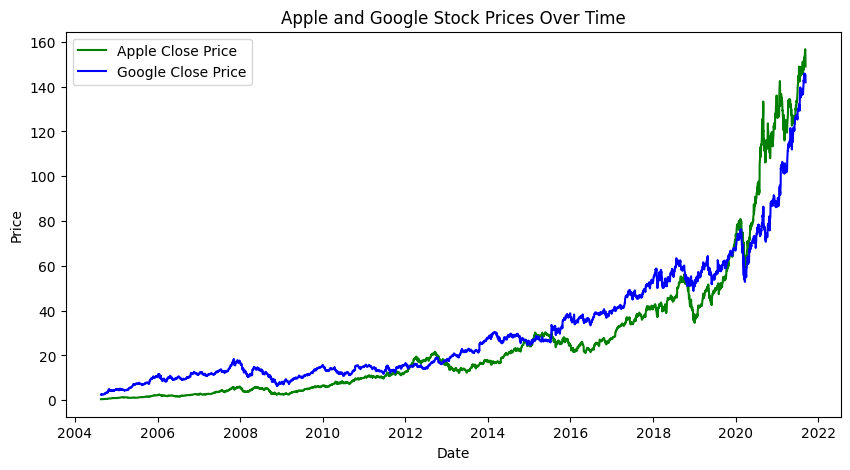

In [117]:
#Plotting a line chart of Apple and Google stock price.
plt.figure(figsize=(10,5))
plt.plot(appleDf['Date'], appleDf['Close'], color='green', label='Apple Close Price')
plt.plot(googleDf['Date'], googleDf['Close'], color='blue', label='Google Close Price')
plt.title('Apple and Google Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [104]:
mergedDf = pd.merge(appleDf, googleDf, on='Date', suffixes=('_AAPL', '_GOOG'))
mergedDf.columns

post2007Df = mergedDf[mergedDf['Date'].dt.year >= 2008].copy()

post2007LSTMwGoog = post2007Df.copy()

In [105]:
#Preprocessing.
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

#Defining the features to be scaled.
featuresScaled = ['Close_AAPL',
                  'MACDSignalAAPL',
                  '%KAAPL',
                  'rollingStd5AAPL',
                  'Month',
                  'Day',
                  'Volume_GOOG',
                  'MACDSignalGOOG',
                  'openCloseDiffGOOG',
                  'dayOfWeek']

#Conducting a time-based train test split for time series data.
cutoffDate = '2018-01-01'
trainData = post2007LSTMwGoog[post2007LSTMwGoog['Date'] < cutoffDate]
testData = post2007LSTMwGoog[post2007LSTMwGoog['Date'] >= cutoffDate]

#Transforming data using MinMaxScaler, fitting to the training data only.
scaler = MinMaxScaler(feature_range=(0, 1))
trainScaled = trainData.copy()
testScaled = testData.copy()

trainScaled[featuresScaled] = scaler.fit_transform(trainData[featuresScaled])
testScaled[featuresScaled] = scaler.transform(testData[featuresScaled])

In [106]:
#LSTM specific preprocessing.
#Creating the required sequences for LSTM.
daysInForecast = 7

features = ['Close_AAPL',
            'MACDSignalAAPL',
            '%KAAPL',
            'rollingStd5AAPL',
            'Month',
            'Day',
            'Volume_GOOG',
            'MACDSignalGOOG',
            'openCloseDiffGOOG',
            'dayOfWeek']
targetVariable = 'Close_AAPL'

xTrain, yTrain = [], []
xTest, yTest = [], []

for i in range(daysInForecast, len(trainScaled)):
    xTrain.append(trainScaled[features].iloc[i - daysInForecast:i].values)
    yTrain.append(trainScaled[targetVariable].iloc[i])
xTrain, yTrain = np.array(xTrain), np.array(yTrain)

for i in range(daysInForecast, len(testScaled)):
    xTest.append(testScaled[features].iloc[i - daysInForecast:i].values)
    yTest.append(testScaled[targetVariable].iloc[i])
xTest, yTest = np.array(xTest), np.array(yTest)

#Splitting the data into training and validation sets.
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, shuffle=False)

In [107]:
#Building an LSTM Model with hyperparameter tuning and multiple layers.
#def buildLSTMModel(units=50, dropoutRate=0.2, learningRate=0.01, l2Reg=0.0, numLayers=1, recurrentDropout=0.0, activation='tanh'):
def buildLSTMModel(units=20, dropoutRate=0.2, learningRate=0.01, l2Reg=0.0, numLayers=1, recurrentDropout=0.0, activation='tanh'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=(numLayers > 1), input_shape=(xTrain.shape[1], xTrain.shape[2]),
                   kernel_regularizer=l2(l2Reg), recurrent_dropout=recurrentDropout, activation=activation))
    model.add(Dropout(dropoutRate))
    if numLayers > 1:
        model.add(LSTM(units=units, kernel_regularizer=l2(l2Reg), recurrent_dropout=recurrentDropout, activation=activation))
        model.add(Dropout(dropoutRate))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learningRate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [108]:
#Establishing a baseline (or untuned) model for comparison.
#Defining baseline parameters for a baseline model.
baselineParams = {'units': 50,
                  'dropoutRate': 0.2,
                  'learningRate': 0.001,
                  'l2Reg': 0.0,
                  'numLayers': 1,
                  'recurrentDropout': 0.0,
                  'activation': 'tanh',}

#Defining a function to train and evaluate the LSTM model.
def trainAndEvaluate(params, epochs=50, batchSize=16):
    model = buildLSTMModel(**params)
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(xTrain, yTrain, epochs=epochs, batch_size=batchSize,
                        verbose=1, validation_data=(xVal, yVal), callbacks=[earlyStopping])
    valLoss = min(history.history['val_loss'])
    return model, valLoss

#Training the baseline model
baselineModel, baselineValLoss = trainAndEvaluate(baselineParams, epochs=50, batchSize=16)
print(f"Baseline Validation Loss: {baselineValLoss}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0296 - val_loss: 0.0103
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0042 - val_loss: 8.0300e-04
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - val_loss: 3.6935e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 6.8610e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 4.2107e-04
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 6.9731e-04
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0905e-04 - val_loss: 9.5789e-04
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6759e-04 - val_loss: 5.2928e-04
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3032e-04 - val_loss: 4.4696e-04
Epoch 12/50
126/12

In [109]:
#Testing parameters to find the best ones.
#Defining the winningest parameter grid.
paramGrid = {'units': [25, 50],
                    'dropoutRate': [0.3, 0.4],
                    'learningRate': [0.001, 0.0001],
                    'l2Reg': [0.001, 0.01],
                    'numLayers': [1],
                    'recurrentDropout': [0.2],
                    'activation': ['tanh', 'linear', 'sigmoid']}

#Tuning individual parameters defined above.
bestParams = baselineParams.copy()
bestValLoss = baselineValLoss
for paramName, paramValues in paramGrid.items():
    for value in paramValues:
        currentParams = bestParams.copy()
        currentParams[paramName] = value
        model, valLoss = trainAndEvaluate(currentParams, epochs=50, batchSize=16)
        #Checking the new model's performance and updating best parameters if improved.
        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestParams[paramName] = value

print(f"Best parameters after individual tuning: {bestParams}")

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0216 - val_loss: 0.0012
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0025 - val_loss: 4.6571e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - val_loss: 7.8097e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - val_loss: 5.8570e-04
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 8.4016e-04
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━

In [110]:
#Training the final LSTM model with the best parameters from paramGrid in every section.
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(xTrain, yTrain, epochs=50, batch_size=16, verbose=1, validation_data=(xVal, yVal), callbacks=[earlyStopping])
finalModel = buildLSTMModel(**bestParams)
history=finalModel.fit(xTrain, yTrain, epochs=50, batch_size=16, verbose=1, validation_data=(xVal, yVal), callbacks=[earlyStopping])

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0060
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - val_loss: 0.0066
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0100
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0075
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0054
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [119]:
#Evaluating the final model on the test set
testForecast = finalModel.predict(xTest)
testForecast = scaler.inverse_transform(np.concatenate([np.zeros((testForecast.shape[0], len(featuresScaled) - 1)), testForecast], axis=1))[:, -1]
testActualPrice = scaler.inverse_transform(np.concatenate([np.zeros((yTest.shape[0], len(featuresScaled) - 1)), yTest.reshape(-1, 1)], axis=1))[:, -1]

#Evaluating the final model on the validation set
valForecast = finalModel.predict(xVal)
valForecast = scaler.inverse_transform(np.concatenate([np.zeros((valForecast.shape[0], len(featuresScaled) - 1)), valForecast], axis=1))[:, -1]
valActualPrice = scaler.inverse_transform(np.concatenate([np.zeros((yVal.shape[0], len(featuresScaled) - 1)), yVal.reshape(-1, 1)], axis=1))[:, -1]

#Calculating LSTM metrics on the test data
testMSE = mean_squared_error(testActualPrice, testForecast)
testRMSE = np.sqrt(testMSE)
testR2 = r2_score(testActualPrice, testForecast)

#Calculating LSTM metrics on the validation data
valMSE = mean_squared_error(valActualPrice, valForecast)
valRMSE = np.sqrt(valMSE)
valR2 = r2_score(valActualPrice, valForecast)

print("Model 3: Using Multiple Apple and Google Variables to Predict Future Apple 'Close' Price")
print(f"Test MSE: {testMSE:<14} | Test RMSE: {testRMSE:<13} | Test R^2: {testR2:<14}")
print(f"Val MSE: {valMSE:<14}   | Val RMSE: {valRMSE:<13}    | Val R^2: {valR2:<14}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 3: Using Multiple Apple and Google Variables to Predict Future Apple 'Close' Price
Test MSE: 0.2274246955713097 | Test RMSE: 0.4768906536841645 | Test R^2: 0.9828521785105506
Val MSE: 0.0028349659384671135   | Val RMSE: 0.05324439818860866    | Val R^2: 0.9930985118167264


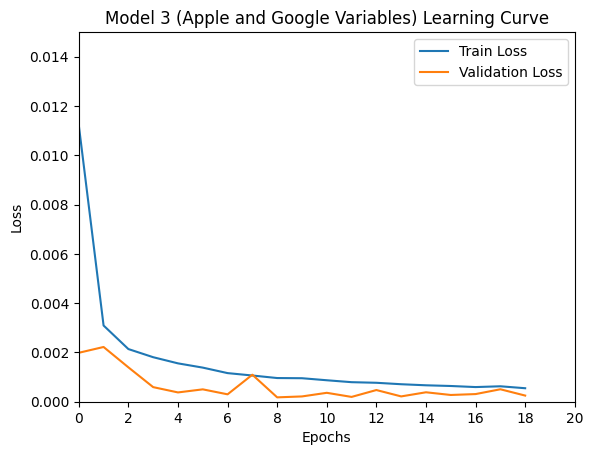

In [118]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model 3 (Apple and Google Variables) Learning Curve')
plt.ylim(0, 0.015)
plt.xticks(np.arange(0, 21, 2))
plt.xlim(0, 20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

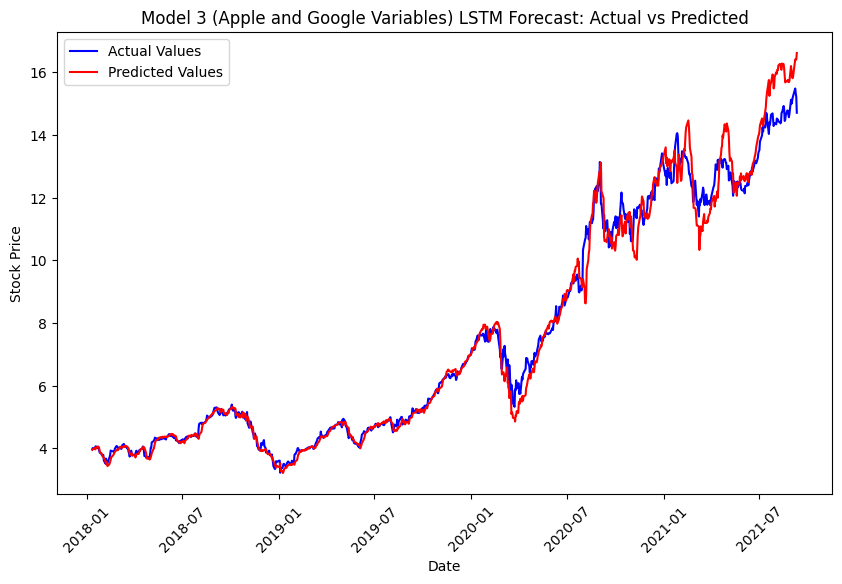

In [116]:
#Extracting the dates to properly format the x axis.
testDates = testData['Date'].iloc[daysInForecast:].values

#Plotting actual vs predicted Apple Stock prices
plt.figure(figsize=(10, 6))
plt.plot(testDates, testActualPrice, label='Actual Values', color='blue')
plt.plot(testDates, testForecast, label='Predicted Values', color='red')
plt.title('Model 3 (Apple and Google Variables) LSTM Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()